# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
import joblib

(A, terms, snippets) = joblib.load("cenario2-tweets-tfidf.pkl")

print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 40336 X 2585 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [2]:
kmin, kmax = 5, 20

Apply NMF for each of these values:

In [3]:
from sklearn import decomposition

topic_models = []

# try each value of k
for k in range(kmin, kmax + 1, 5):
    print("Applying NMF for k=%d ..." % k)
    # run NMF
    model = decomposition.NMF(init="nndsvd", n_components=k)
    W = model.fit_transform(A)
    H = model.components_
    # store for later
    topic_models.append((k, W, H))

Applying NMF for k=5 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [4]:
import os.path

raw_documents = []

with open(os.path.join("../../././../../../data-pre-processing/2csv/cenario2_8M2020_tweets_pt.txt"), "r") as fin:
    for line in fin.readlines():
        raw_documents.append(line.strip().lower())

print("Read %d raw text documents" % len(raw_documents))

Read 40336 raw text documents


Read the custom stopword list:

In [5]:
custom_stop_words = []

with open("portuguese.txt", "r") as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 231 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [6]:
import re


class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok)
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [7]:
import gensim

In [8]:
docgen = TokenGenerator(raw_documents, custom_stop_words)

# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [9]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 2623 terms


Save for later use, so that we do not need to rebuild it:

In [10]:
w2v_model.save("cenario2_w2v-model.bin")

In [11]:
# To re-load this model, run
# w2v_model = gensim.models.Word2Vec.load("cenario1_w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [12]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [13]:
import numpy as np


def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    
    return top_terms

Now process each of the models for different values of *k*:

# 5

In [14]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 5))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.5374
K=10: Coherence=0.5273
K=15: Coherence=0.5056
K=20: Coherence=0.5487


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

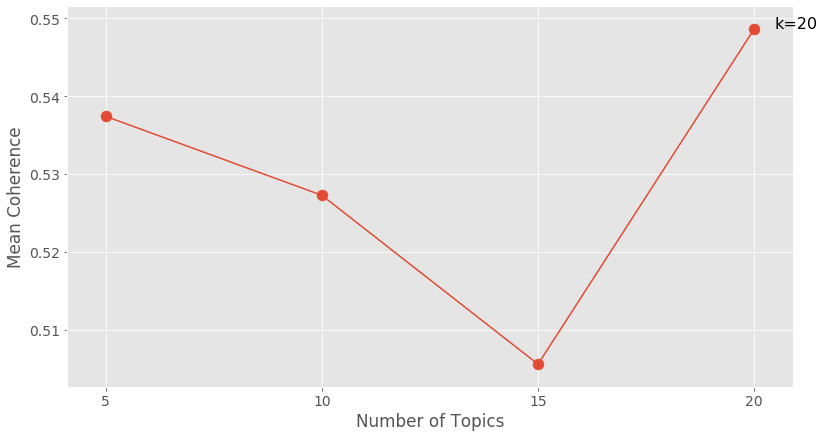

In [16]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 10

In [17]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.5111
K=10: Coherence=0.4985
K=15: Coherence=0.5028
K=20: Coherence=0.5390


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


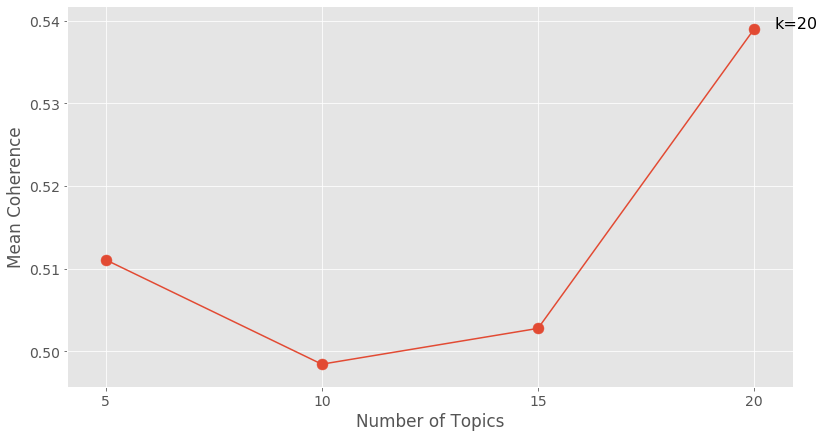

In [18]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 15 

In [19]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 15))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.5013
K=10: Coherence=0.4981
K=15: Coherence=0.4906
K=20: Coherence=0.5332


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


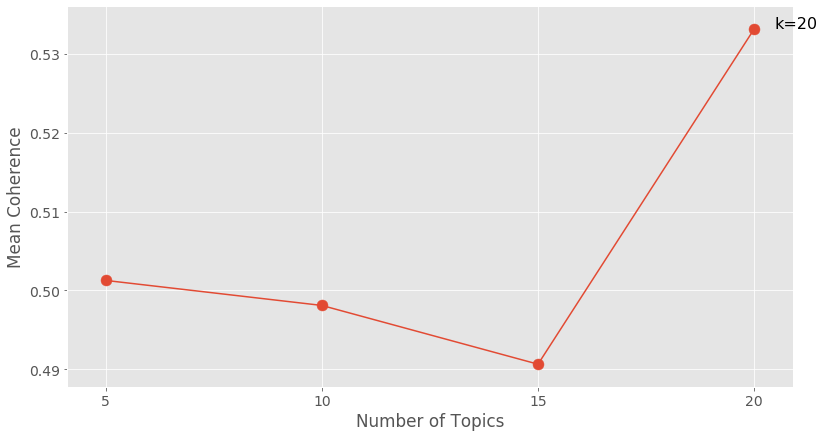

In [20]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 20

In [21]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 20))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


K=05: Coherence=0.4803
K=10: Coherence=0.4904
K=15: Coherence=0.4873
K=20: Coherence=0.5367


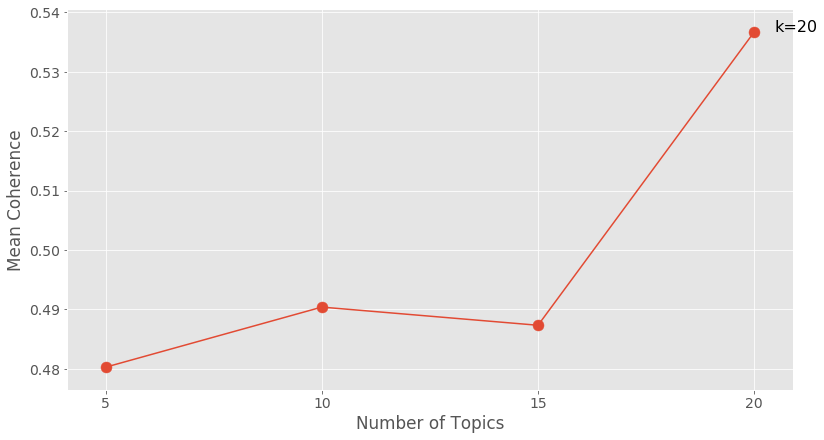

In [22]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

In [23]:
k = 5 # best_k

# get the model that we generated earlier.
W = topic_models[0][1]
H = topic_models[0][2]

Display the topic descriptors for this model:

In [24]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, marco, homenagem
Topic 02: mulheres, parabens, guerreiras, dia, mundo
Topic 03: feliz, dia, guerreiras, dias, mundo
Topic 04: hoje, ser, sororidade, dias, luta
Topic 05: amo, video, tanto, demais, vida


In [25]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, marco, homenagem, parabens, bom, especial, via, hoje
Topic 02: mulheres, parabens, guerreiras, dia, mundo, luta, brasil, vida, especial, incriveis
Topic 03: feliz, dia, guerreiras, dias, mundo, vcs, incriveis, mulheres, bom, maravilhosas
Topic 04: hoje, ser, sororidade, dias, luta, respeito, sempre, tudo, quero, gente
Topic 05: amo, video, tanto, demais, vida, tudo, deus, melhor, perfeito, mae


In [26]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, marco, homenagem, parabens, bom, especial, via, hoje, amanha, mae, comemoracao, domingo, comemorar
Topic 02: mulheres, parabens, guerreiras, dia, mundo, luta, brasil, vida, especial, incriveis, marco, fortes, vcs, dias, direitos
Topic 03: feliz, dia, guerreiras, dias, mundo, vcs, incriveis, mulheres, bom, maravilhosas, deseja, merecem, lindas, desejar, linda
Topic 04: hoje, ser, sororidade, dias, luta, respeito, sempre, tudo, quero, gente, sim, vai, ter, sobre, homem
Topic 05: amo, video, tanto, demais, vida, tudo, deus, melhor, perfeito, mae, serie, nunca, sempre, amor, vcs


In [27]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, marco, homenagem, parabens, bom, especial, via, hoje, amanha, mae, comemoracao, domingo, comemorar, presente, data, lugar, vida, forca
Topic 02: mulheres, parabens, guerreiras, dia, mundo, luta, brasil, vida, especial, incriveis, marco, fortes, vcs, dias, direitos, homenagem, maravilhosas, lindas, contra, merecem
Topic 03: feliz, dia, guerreiras, dias, mundo, vcs, incriveis, mulheres, bom, maravilhosas, deseja, merecem, lindas, desejar, linda, fortes, sempre, desejamos, amor, mulherada
Topic 04: hoje, ser, sororidade, dias, luta, respeito, sempre, tudo, quero, gente, sim, vai, ter, sobre, homem, flores, ano, pode, ainda, igualdade
Topic 05: amo, video, tanto, demais, vida, tudo, deus, melhor, perfeito, mae, serie, nunca, sempre, amor, vcs, vou, linda, cara, pqp, mulher


# 10

In [28]:
k = 10 # best_k

# get the model that we generated earlier.
W = topic_models[1][1]
H = topic_models[1][2]

In [29]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, marco, homenagem
Topic 02: mulheres, dia, vida, guerreiras, luta
Topic 03: feliz, dia, guerreiras, vcs, dias
Topic 04: ser, mulher, quero, vai, homem
Topic 05: parabens, guerreiras, dia, vcs, marco
Topic 06: amo, tanto, demais, vida, deus
Topic 07: hoje, dias, luta, dia, respeito
Topic 08: sororidade, ter, marcela, gente, feminismo
Topic 09: video, tudo, perfeito, melhor, nunca
Topic 10: mundo, melhor, vcs, merecem, guerreiras


In [30]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, marco, homenagem, especial, bom, via, amanha, mae
Topic 02: mulheres, dia, vida, guerreiras, luta, homenagem, incriveis, direitos, fortes, contra
Topic 03: feliz, dia, guerreiras, vcs, dias, bom, maravilhosas, incriveis, deseja, lindas
Topic 04: ser, mulher, quero, vai, homem, tudo, pode, vida, quiser, sim
Topic 05: parabens, guerreiras, dia, vcs, marco, especial, deus, bom, lindas, brasil
Topic 06: amo, tanto, demais, vida, deus, mae, amor, serie, linda, vcs
Topic 07: hoje, dias, luta, dia, respeito, sempre, igualdade, ano, direitos, flores
Topic 08: sororidade, ter, marcela, gente, feminismo, sobre, cara, empatia, caralho, amiga
Topic 09: video, tudo, perfeito, melhor, nunca, sempre, bom, vou, ver, vez
Topic 10: mundo, melhor, vcs, merecem, guerreiras, tudo, amor, brasil, respeito, forca


In [31]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, marco, homenagem, especial, bom, via, amanha, mae, domingo, comemoracao, comemorar, presente, vida
Topic 02: mulheres, dia, vida, guerreiras, luta, homenagem, incriveis, direitos, fortes, contra, especial, brasil, homens, marco, outras
Topic 03: feliz, dia, guerreiras, vcs, dias, bom, maravilhosas, incriveis, deseja, lindas, desejar, merecem, linda, fortes, sempre
Topic 04: ser, mulher, quero, vai, homem, tudo, pode, vida, quiser, sim, sempre, ter, gente, deve, fazer
Topic 05: parabens, guerreiras, dia, vcs, marco, especial, deus, bom, lindas, brasil, dias, mulherada, sempre, batalhadoras, fortes
Topic 06: amo, tanto, demais, vida, deus, mae, amor, serie, linda, vcs, obrigada, mulher, musica, cara, caralho
Topic 07: hoje, dias, luta, dia, respeito, sempre, igualdade, ano, direitos, flores, bom, outros, sim, queremos, data
Topic 08: sororidade, ter, marcela, gente, feminismo, sobre, cara, empatia, caralho, amiga, nao, cade, aqui, feminista, porrada


In [32]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, marco, homenagem, especial, bom, via, amanha, mae, domingo, comemoracao, comemorar, presente, vida, sobre, lugar, data, homem, quiser
Topic 02: mulheres, dia, vida, guerreiras, luta, homenagem, incriveis, direitos, fortes, contra, especial, brasil, homens, marco, outras, maravilhosas, aqui, sobre, bolsonaro, historia
Topic 03: feliz, dia, guerreiras, vcs, dias, bom, maravilhosas, incriveis, deseja, lindas, desejar, merecem, linda, fortes, sempre, desejamos, mulherada, seguidoras, brazil, amigas
Topic 04: ser, mulher, quero, vai, homem, tudo, pode, vida, quiser, sim, sempre, ter, gente, deve, fazer, nunca, lugar, amor, ainda, assim
Topic 05: parabens, guerreiras, dia, vcs, marco, especial, deus, bom, lindas, brasil, dias, mulherada, sempre, batalhadoras, fortes, principalmente, maravilhosas, abencoe, guerreira, meninas
Topic 06: amo, tanto, demais, vida, deus, mae, amor, serie, linda, vcs, obrigada, mulher, musica, cara, caralho, perfeita, cena, che

# 15

In [33]:
k = 15 # best_k

# get the model that we generated earlier.
W = topic_models[2][1]
H = topic_models[2][2]

In [34]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, homenagem, via
Topic 02: mulheres, vida, incriveis, homenagem, homens
Topic 03: feliz, dia, dias, deseja, incriveis
Topic 04: ser, vai, homem, mulher, sempre
Topic 05: parabens, especial, deus, mulherada, brasil
Topic 06: amo, tanto, demais, vida, mae
Topic 07: hoje, dias, respeito, sempre, ano
Topic 08: sororidade, ter, marcela, feminismo, sobre
Topic 09: video, melhor, perfeito, sempre, nunca
Topic 10: luta, direitos, igualdade, contra, respeito
Topic 11: mundo, melhor, merecem, vcs, amor
Topic 12: tudo, quero, sim, gente, flores
Topic 13: dia, bom, internacional, especial, cada
Topic 14: guerreiras, vcs, lindas, fortes, dias
Topic 15: marco, homenagem, data, respeito, ano


In [35]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, homenagem, via, mae, vida, lugar, quiser, amanha
Topic 02: mulheres, vida, incriveis, homenagem, homens, especial, fortes, brasil, outras, maravilhosas
Topic 03: feliz, dia, dias, deseja, incriveis, maravilhosas, desejar, sempre, linda, vcs
Topic 04: ser, vai, homem, mulher, sempre, pode, quiser, ter, vida, deve
Topic 05: parabens, especial, deus, mulherada, brasil, sempre, guerreira, meninas, abencoe, amor
Topic 06: amo, tanto, demais, vida, mae, deus, amor, serie, linda, vcs
Topic 07: hoje, dias, respeito, sempre, ano, outros, porque, maior, ontem, receber
Topic 08: sororidade, ter, marcela, feminismo, sobre, gente, cara, empatia, caralho, amiga
Topic 09: video, melhor, perfeito, sempre, nunca, bom, ver, vou, vez, vejo
Topic 10: luta, direitos, igualdade, contra, respeito, vamos, violencia, sempre, data, ruas
Topic 11: mundo, melhor, merecem, vcs, amor, brasil, merece, forca, pessoas, incriveis
Topic 12: tudo, quero, sim, gente, flores, respeito,

In [36]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, homenagem, via, mae, vida, lugar, quiser, amanha, sobre, onde, casa, homem, deus
Topic 02: mulheres, vida, incriveis, homenagem, homens, especial, fortes, brasil, outras, maravilhosas, aqui, contra, trans, marcha, fazem
Topic 03: feliz, dia, dias, deseja, incriveis, maravilhosas, desejar, sempre, linda, vcs, desejamos, respeito, amor, mulherada, seguidoras
Topic 04: ser, vai, homem, mulher, sempre, pode, quiser, ter, vida, deve, assim, nunca, orgulho, fazer, ainda
Topic 05: parabens, especial, deus, mulherada, brasil, sempre, guerreira, meninas, abencoe, amor, linda, principalmente, dar, vcs, brazil
Topic 06: amo, tanto, demais, vida, mae, deus, amor, serie, linda, vcs, obrigada, musica, cara, caralho, homem
Topic 07: hoje, dias, respeito, sempre, ano, outros, porque, maior, ontem, receber, apenas, flores, presente, queremos, especial
Topic 08: sororidade, ter, marcela, feminismo, sobre, gente, cara, empatia, caralho, amiga, nao, cade, feminista, p

In [37]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, homenagem, via, mae, vida, lugar, quiser, amanha, sobre, onde, casa, homem, deus, brasil, presente, guerreira, linda, pleno
Topic 02: mulheres, vida, incriveis, homenagem, homens, especial, fortes, brasil, outras, maravilhosas, aqui, contra, trans, marcha, fazem, inspiram, negras, historia, direitos, bolsonaro
Topic 03: feliz, dia, dias, deseja, incriveis, maravilhosas, desejar, sempre, linda, vcs, desejamos, respeito, amor, mulherada, seguidoras, brazil, lindas, merecem, rainhas, amigas
Topic 04: ser, vai, homem, mulher, sempre, pode, quiser, ter, vida, deve, assim, nunca, orgulho, fazer, ainda, forte, deveria, amor, sabe, nada
Topic 05: parabens, especial, deus, mulherada, brasil, sempre, guerreira, meninas, abencoe, amor, linda, principalmente, dar, vcs, brazil, esposa, forca, boa, respeito, noite
Topic 06: amo, tanto, demais, vida, mae, deus, amor, serie, linda, vcs, obrigada, musica, cara, caralho, homem, cena, cher, perfeita, admiro, foto
Top

# 20

In [38]:
k = 20 # best_k

# get the model that we generated earlier.
W = topic_models[3][1]
H = topic_models[3][2]

In [39]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, bom, via
Topic 02: mulheres, dia, vida, incriveis, especial
Topic 03: feliz, dia, deseja, incriveis, desejar
Topic 04: sobre, vai, aqui, homem, nada
Topic 05: parabens, especial, brasil, mulherada, meninas
Topic 06: amo, tanto, demais, vida, serie
Topic 07: hoje, dia, bom, especial, ontem
Topic 08: sororidade, marcela, ter, empatia, feminismo
Topic 09: video, perfeito, melhor, nunca, bom
Topic 10: ser, mulher, pode, deve, quiser
Topic 11: mundo, melhor, merecem, vcs, brasil
Topic 12: quero, sim, flores, bombom, respeito
Topic 13: luta, direitos, igualdade, contra, dia
Topic 14: guerreiras, vcs, dia, lindas, fortes
Topic 15: marco, dia, data, comemorado, ano
Topic 16: tudo, faz, bom, acima, bem
Topic 17: homenagem, linda, especial, forca, singela
Topic 18: gente, linda, coisa, quer, bom
Topic 19: dias, respeito, ano, outros, queremos
Topic 20: sempre, deus, vida, amor, abencoe


In [40]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, bom, via, especial, mae, amanha, comemoracao, comemorar
Topic 02: mulheres, dia, vida, incriveis, especial, fortes, outras, homens, brasil, maravilhosas
Topic 03: feliz, dia, deseja, incriveis, desejar, maravilhosas, linda, vcs, desejamos, mulherada
Topic 04: sobre, vai, aqui, homem, nada, ainda, fazer, nunca, ter, vamos
Topic 05: parabens, especial, brasil, mulherada, meninas, guerreira, dia, principalmente, vcs, dar
Topic 06: amo, tanto, demais, vida, serie, mae, vcs, obrigada, musica, linda
Topic 07: hoje, dia, bom, especial, ontem, porque, outros, celebrar, lembrar, aniversario
Topic 08: sororidade, marcela, ter, empatia, feminismo, caralho, cara, cade, amiga, porrada
Topic 09: video, perfeito, melhor, nunca, bom, vez, ver, maravilhoso, vejo, vou
Topic 10: ser, mulher, pode, deve, quiser, vida, deveria, orgulho, forte, homem
Topic 11: mundo, melhor, merecem, vcs, brasil, merece, forca, incriveis, pessoas, amor
Topic 12: quero, sim, flores, bomb

In [41]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, bom, via, especial, mae, amanha, comemoracao, comemorar, presente, domingo, pleno, mensagem, lugar
Topic 02: mulheres, dia, vida, incriveis, especial, fortes, outras, homens, brasil, maravilhosas, direitos, trans, marcha, contra, negras
Topic 03: feliz, dia, deseja, incriveis, desejar, maravilhosas, linda, vcs, desejamos, mulherada, seguidoras, brazil, lindas, rainhas, amigas
Topic 04: sobre, vai, aqui, homem, nada, ainda, fazer, nunca, ter, vamos, vou, dar, homens, falar, bem
Topic 05: parabens, especial, brasil, mulherada, meninas, guerreira, dia, principalmente, vcs, dar, cada, brazil, abencoe, esposa, pais
Topic 06: amo, tanto, demais, vida, serie, mae, vcs, obrigada, musica, linda, caralho, amor, mulher, admiro, cara
Topic 07: hoje, dia, bom, especial, ontem, porque, outros, celebrar, lembrar, aniversario, anos, celebramos, data, entao, homenagear
Topic 08: sororidade, marcela, ter, empatia, feminismo, caralho, cara, cade, amiga, porrada, femi

In [42]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mulher, internacional, dia, bom, via, especial, mae, amanha, comemoracao, comemorar, presente, domingo, pleno, mensagem, lugar, vida, aniversario, casa, guerreira, otimo
Topic 02: mulheres, dia, vida, incriveis, especial, fortes, outras, homens, brasil, maravilhosas, direitos, trans, marcha, contra, negras, inspiram, fazem, bolsonaro, pras, historia
Topic 03: feliz, dia, deseja, incriveis, desejar, maravilhosas, linda, vcs, desejamos, mulherada, seguidoras, brazil, lindas, rainhas, amigas, merecem, meninas, fodas, bom, foda
Topic 04: sobre, vai, aqui, homem, nada, ainda, fazer, nunca, ter, vamos, vou, dar, homens, falar, bem, ver, onde, lugar, feminismo, quiser
Topic 05: parabens, especial, brasil, mulherada, meninas, guerreira, dia, principalmente, vcs, dar, cada, brazil, abencoe, esposa, pais, boa, vez, forca, obrigado, noite
Topic 06: amo, tanto, demais, vida, serie, mae, vcs, obrigada, musica, linda, caralho, amor, mulher, admiro, cara, perfeita, cena, cher, pqp, foda
Top